

[230. 235. 240. 245. 250. 255. 260. 265. 270. 275. 280. 285. 290. 295.
 300. 305. 310. 315. 320. 325. 330. 335. 340. 345. 350. 355. 360. 365.
 370. 375. 380. 385. 390. 395. 400. 405. 410. 415. 420. 425. 430. 435.
 440. 445. 450. 455. 460. 465. 470. 475. 480. 485. 490. 495. 500.]
[240. 242. 244. 246. 248. 250. 252. 254. 256. 258. 260. 262. 264. 266.
 268. 270. 272. 274. 276. 278. 280. 282. 284. 286. 288. 290. 292. 294.
 296. 298. 300. 302. 304. 306. 308. 310. 312. 314. 316. 318. 320. 322.
 324. 326. 328. 330. 332. 334. 336. 338. 340. 342. 344. 346. 348. 350.
 352. 354. 356. 358. 360. 362. 364. 366. 368. 370. 372. 374. 376. 378.
 380. 382. 384. 386. 388. 390. 392. 394. 396. 398. 400. 402. 404. 406.
 408. 410. 412. 414. 416. 418. 420. 422. 424. 426. 428. 430. 432. 434.
 436. 438. 440. 442. 444. 446. 448. 450. 452. 454. 456. 458. 460. 462.
 464. 466. 468. 470. 472. 474. 476. 478. 480. 482. 484. 486. 488. 490.
 492. 494. 496. 498. 500. 502. 504. 506. 508. 510. 512. 514. 516. 518.
 520. 52

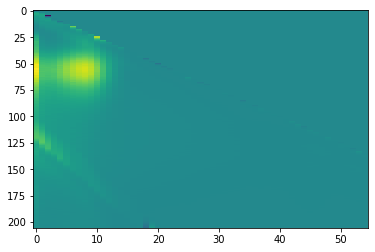

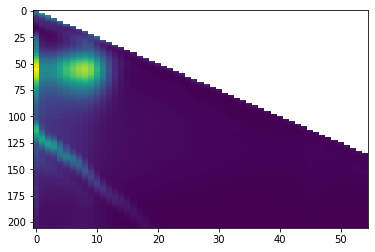

0
[510.0, 512.0, 514.0, 516.0, 518.0]
[0.01644818 0.02911317 0.03362665 0.03259685 0.02863202]


In [46]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import math
import functools
import numpy as np
import scipy.interpolate
from scipy import interpolate
import pandas as pd
import pickle as pkl

def is_nan(x):
    return (x is np.nan or x != x)

# y = the regressors, a simple 2D array
y =pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/y.txt', sep= '\t')
y = y.replace(',','.', regex=True) #меняю ',' на '.'
y = y.astype(float) #конвертирую из string в float
y=y.assign(Gominy=y[["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"]].sum(1)) #складываю столбцы
y=y.drop(["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"], axis=1) #удаляю ненужные столбцы
y = y[['Gominy'] + y.columns[:-1].tolist()] #меняю порядок столбцов так, чтобы первым был Gominy
y.to_pickle('C:/Users/admin/Desktop/курсовая 2.0/y.pkl.gz') #сохраняем в pickle формате, удобном для регрессии
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
print()

# save the result
y.to_pickle('C:/Users/admin/Desktop/курсовая 2.0/y.pkl.gz')

# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
k = 0
X=np.zeros([35,206,55]) #инициализирую массив нулей

fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) #формируем список файлов x для считывания в цикле

xw = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/01.txt',sep='\t')
colums=list(xw.columns.values) #установил имена колонок
rows=list(xw.index.values)  #установил имена строчек
ll=xw.columns.values #колонки
lrl=xw.index.values #строчки
lrl=lrl.astype(float)
ll=ll.astype(float)
Xw=np.zeros([206,55]) #инициализирую массив нулей
for i in range(0,206):
    for j in range(0,55):
        if (math.fabs((2*ll[j])-lrl[i])<20) or (math.fabs(ll[j]-lrl[i])<20):
            Xw[i,j]=1.0  #собираю булеву матрицу
       
        
            
print()
print(ll)
print(lrl)

while k < 35:
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[k],sep='\t')
    xzxz=pd.isnull(x) #проверяю элементы на np.nan
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    Xx=np.zeros([206,55]) #инициализирую массив нулей
    for gg in range(0,55):
        tt=[]  #будущий набор из названий строк для интерполяции
        a3=[]
        f2=[]
        f3=[]
        f4=[]
        f5=[]
        fgh=x.iloc[:,gg]
        gh=0
        kj=0
        lk=0
        for i in range(0,206):
            if (xzxz.iloc[i,gg]==False):
                if (math.fabs(Xw[i,gg]-1)<0.5): #область для интерполяции
                    tt+=[lrl[i]]
                    gh+=1
                if (math.fabs(Xw[i,gg]-1)>0.5):  #область для получения интерполяционного многочлена
                    a3+=[lrl[i]]
                    f2+=[fgh.iloc[i]]
                    f3+=[lrl[i]]
                    kj+=1
            if (xzxz.iloc[i,gg]==True):
                f4+=[lrl[i]]
                lk+=1
        
        if (len(a3)>1) and (len(f2)>1):
            a1=scipy.interpolate.PchipInterpolator(a3,f2)
            a2=a1(tt).astype(float)
        else:
            a2=0.0
        v=0
        vc=0
        cv=0
        kkk=0
        
        for i in range(0,206):
            if (len(f4)>0.5) and (v<len(f4)):
                if (math.fabs(lrl[i]-f4[v])<1):
                    f5+=[0.0]
                    v+=1
            if (len(f3)>0.5) and (vc<len(f3)):
                if (math.fabs(lrl[i]-f3[vc])<1):
                    f5+=[f2[vc]]
                    vc+=1
            if (len(tt)>0.5) and (cv<len(tt)):
                if (math.fabs(lrl[i]-tt[cv])<1):
                    f5+=[a2[cv]]
                    cv+=1
            kkk+=1
        
        Xx[:,gg]+=f5
    X[k,:,:]+=Xx #собираю тензор
    k = k + 1
# save the fluorescence intensity values together with wavelengths
# (like Matlab, NumPy doesn't seem to have the concept
# of "named dimensions" in >2-dimensional arrays)
pkl.dump(
	{'X': X, 'emission': X_[0].axes[0].values, 'excitation': X_[1].axes[1].values},
	open('C:/Users/admin/Desktop/курсовая 2.0/X.pkl.gz', 'wb')
)

import matplotlib.pyplot as plt
plt.imshow(Xx,aspect="auto")
plt.show();
plt.imshow(x,aspect="auto")
plt.show();
print(len(a33))
print(tt)
print(a2)